In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!ls /content/gdrive/'MyDrive'/'Colab Notebooks'/ -la
!cp /content/gdrive/'MyDrive'/'Colab Notebooks'/archive.zip .

total 1440261
-rw------- 1 root root  363152213 Dec  7 02:13 archive.zip
-rw------- 1 root root 1111530564 Dec  8 07:20 images.tar.gz
-rw------- 1 root root     143394 Dec 15 08:46 Untitled0.ipynb


In [3]:
!unzip archive.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jpg  
  inflating

In [4]:
!nvidia-smi

Mon Dec 21 21:47:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix
from skimage.feature import greycomatrix, greycoprops
import matplotlib.pyplot as plt
from scipy import signal as sg
import itertools
import numpy as np
import cv2
import os

# --- Train, Test 이미지 패치 추출 ---
train_dir = './seg_train/seg_train' #train data path
test_dir = './seg_test/seg_test' #test data path
classes = ['buildings','forest','mountain','sea'] #class 이름 배열

# --- Train 이미지 패치 추출 ---
X_train = []
Y_train = []

np.random.seed(1234)
for idx, texture_name in enumerate(classes): #각 클래스 개수 4개까지
    image_dir = os.path.join(train_dir, texture_name) #train data 중 각 class에 있는 경로 중
    for image_name in os.listdir(image_dir): #class data 중 이미지가 있는 경로에 접근
        image = cv2.imread(os.path.join(image_dir, image_name)) #이미지 읽고
        image = cv2.resize(image, (150, 150), interpolation = cv2.INTER_LINEAR) #150*150의 크기로 모두 동일하게 함
        X_train.append(image) #test image와 train image 모두 150*150으로 같기 때문에 따로 crop하지 않음
        Y_train.append(idx) #각 label을 추가 buildings : 0, forest : 1, mountain : 2, sea : 3

#numpy array로 선언 뒤 출력            
X_train = np.array(X_train)/128 -1
Y_train = np.array(Y_train)
print('train data: ', X_train.shape)
print('train label: ', Y_train.shape)
print('\n')

X_test = []
Y_test = []

for idx, texture_name in enumerate(classes): #각 클래스 개수 4개까지
    image_dir = os.path.join(test_dir, texture_name) #train data 중 각 class에 있는 경로 중
    for image_name in os.listdir(image_dir): #class data 중 이미지가 있는 경로에 접근
        image = cv2.imread(os.path.join(image_dir, image_name)) #이미지 읽고
        image = cv2.resize(image, (150, 150), interpolation = cv2.INTER_LINEAR) #150*150의 크기로 모두 동일하게 함
        X_test.append(image)
        Y_test.append(idx) #각 label을 추가 buildings : 0, forest : 1, mountain : 2, sea : 3

X_test = np.array(X_test)/128 -1
Y_test = np.array(Y_test)
print('test data : ', X_test.shape)
print('test label : ', Y_test.shape)
print('\n')

train data:  (9248, 150, 150, 3)
train label:  (9248,)


test data :  (1946, 150, 150, 3)
test label :  (1946,)




In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchsummary import summary

# --- 데이터셋 클래스 ---
class textureDataset(Dataset): #dataset 클래스
    def __init__(self, images, labels): #initialization
        self.images = images #x, 이미지
        self.labels = labels #y, 라벨
        
    def __len__(self): #데이터셋 크기 구하는 함수
        return len(self.labels) 
    
    def __getitem__(self,idx): # idx 번째 샘플을 반환
        if torch.is_tensor(idx): #idx가 pytorch tensor면
            idx= idx.tolist() #idx를 list로 변환
        image = self.images[idx]
        label = self.labels[idx]
        sample = (image, label) #idx번째 특징과 라벨을 샘플로 묶어 반환
        return sample
    
# --- 신경망 모델 클래스 ---    
class MLP(nn.Module): #MLP class
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim): #initalization
        super(MLP, self).__init__() 
        self.fc1 = nn.Linear(input_dim, hidden_dim1) #fc1 : input dimmension *hidden dimension1
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim1) #fc2 : hidden dimension1 * hidden dimension1
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2) #fc3 : hidden dimension1 *hidden dimension2
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim2) #fc3 : hidden dimension2 *hidden dimension2
        self.fc5 = nn.Linear(hidden_dim2, output_dim) #fc3 : hidden dimension2 *output dimension
        self.dropout = nn.Dropout(p = 0.5)
        self.relu = nn.ReLU()
    
    def forward(self, x): #x : input_dim
        x = torch.flatten(x,1) #3차원 rgb를 flatten
        out = self.fc1(x) #out : hidden_dim1
        out = self.relu(out) #out : hidden_dim1
        out = self.fc2(out) #out : hidden_dim1
        out = self.relu(out) #out : hidden_dim1
        out = self.dropout(out)
        out = self.fc3(out) #out : hidden_dim2
        out = self.relu(out) #out : hidden_dim2
        out = self.fc4(out) #out : hidden_dim2
        out = self.relu(out) #out : hidden_dim2
        out = self.fc5(out) #out : output_dim
        return out

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #GPU : 'cuda', CPU : 'cpu'

batch_size = 10 #배치 사이즈
learning_rate = 0.001 #학습률
n_epoch = 100 #epoch

Train_data = textureDataset(images = X_train, labels = Y_train) #train data 정의
Test_data = textureDataset(images = X_test, labels = Y_test) # test data 정의

Trainloader = DataLoader(Train_data, batch_size = batch_size, shuffle = True) #train data loader 정의
Testloader = DataLoader(Test_data, batch_size = batch_size) #test data loader 정의

net = MLP(150*150*3, 1024, 128, 4) #MLP 모델 정의
net.to(device) #모델을 device로 보냄
summary(net, (150, 150, 3), device = 'cuda' if torch.cuda.is_available() else 'cpu') #해당 MLP model layer summary

optimizer = optim.Adam(net.parameters(), lr = learning_rate) #optimizer 정의
criterion = nn.CrossEntropyLoss() #loss 계산식은 multi class이므로 crossentropy

train_losses = [] #학습 loss 저장할 배열
train_accs = [] #학습 accuracy 저장할 배열
test_losses = [] #validation loss 저장할 배열
test_accs = [] #validation accuracy 저장할 배열

# --- 학습 ---
for epoch in range(n_epoch):
    train_loss = 0.0
    evaluation = []
    net.train()
    for i, data in enumerate(Trainloader, 0):
        features, labels = data
        labels = labels.long().to(device)
        features = features.to(device)
        optimizer.zero_grad()
        
        outputs = net(features.to(torch.float))
        
        _, predicted = torch.max(outputs.cpu().data, 1)
        evaluation.append((predicted == labels.cpu()).tolist())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss = train_loss/(i+1)
    evaluation = [item for sublist in evaluation for item in sublist]
    train_acc = sum(evaluation)/len(evaluation)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # --- 테스트 ---
    if (epoch+1) % 1 == 0:
        test_loss = 0.0
        evaluation = []
        net.eval()
        for i, data in enumerate(Testloader, 0):
            features, labels = data
            labels = labels.long().to(device)
            features = features.to(device)
            
        
            outputs = net(features.to(torch.float))
        
            _, predicted = torch.max(outputs.cpu().data, 1)
            evaluation.append((predicted == labels.cpu()).tolist())
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    test_loss = test_loss/(i+1)
    evaluation = [item for sublist in evaluation for item in sublist]
    test_acc = sum(evaluation)/len(evaluation)
    
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print('[%d, %3d]\tloss: %.4f\tAccuracy : %.4f\t\tval-loss : %.4f\tval_Accuracy : %.4f' %(epoch+1, n_epoch, train_loss, train_acc, test_loss, test_acc))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]      69,121,024
              ReLU-2                 [-1, 1024]               0
            Linear-3                 [-1, 1024]       1,049,600
              ReLU-4                 [-1, 1024]               0
           Dropout-5                 [-1, 1024]               0
            Linear-6                  [-1, 128]         131,200
              ReLU-7                  [-1, 128]               0
            Linear-8                  [-1, 128]          16,512
              ReLU-9                  [-1, 128]               0
           Linear-10                    [-1, 4]             516
Total params: 70,318,852
Trainable params: 70,318,852
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 0.04
Params size (MB): 268.25
Est

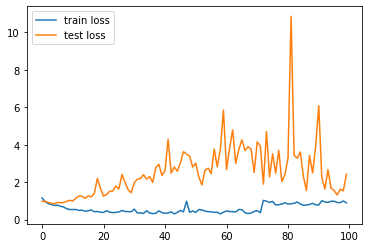

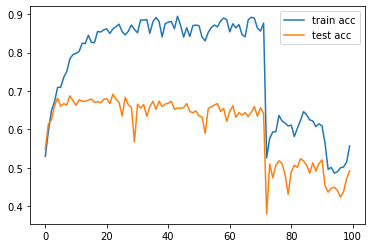

In [5]:
# --- train/test loss/acc visualization ---
plt.plot(range(len(train_losses)), train_losses, label = 'train loss')
plt.plot(range(len(test_losses)), test_losses, label = 'test loss')
plt.legend()
plt.show()
plt.plot(range(len(train_accs)), train_accs, label = 'train acc')
plt.plot(range(len(test_accs)), test_accs, label = 'test acc')
plt.legend()
plt.show()